# real-estate

## Abstract

## Scope and Objectives

The purpose of this notebook is to develop a regression model for the sale price of houses

## Libraries

In [39]:
import pandas as pd
from pandas_profiling import ProfileReport
from PythonFiles import reader as r
import prince

## Exploration - Reducing Dimensions

In [23]:
path = 'Data/data.csv'
df = r.get_housing_data(path) # unnecessary change to your function, just did this out of curiosity
df.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


**NOTE:** running the next 3 cells (already commneted) will take a considerable amount of time. The outcome of these 3 cells can be found in 'Reporting/profile.html'. 

In [24]:
#profile = df.profile_report()

In [25]:
#profile

In [26]:

#profile.to_file('Reporting/profile.html')

In [27]:
df_temp = df.copy()

# drop attributes which contain > 30% missing values
df_temp.drop(['PoolQC','Fence','Alley','FireplaceQu','MiscFeature'], axis = 1, inplace = True)

# drop attributes that are redundant / meaningless based on our knowledge
df_temp.drop(['Order','PID','SaleType'], axis = 1, inplace = True)

# drop attributes that have very little correlation with everything (based on the correlation graph generated)
df_temp.drop(['3SsnPorch', 'ScreenPorch','PoolArea',
              'MiscVal','MoSold','YrSold','MSZoning',
              'MSSubClass','LotFrontage','LotArea',
              'LotShape','LotConfig','BldgType',
              'HouseStyle'], axis = 1, inplace = True)

# drop attributes that are highly skewed with weak correlations
# Examples: 99.5% of 'street' is 'Pave'

df_temp.drop(['Street','LandContour','Utilities','LandSlope',
              'Condition1','Condition2','RoofMatl','BsmtCond','PavedDrive',
              'KitchenAbvGr','Functional','EnclosedPorch','CentralAir',
              'GarageCond','GarageQual','BsmtHalfBath','LowQualFinSF','Electrical',
              'LandContour','LandSlope','ExterCond'], axis = 1, inplace = True)

# drop values that may mislead our analysis (this includes things that are incorrectly
# stored, for instance: year remod/add = year constructed if no remodelling as been done)
df_temp.drop(['YearRemod/Add','GarageCars'],axis = 1, inplace = True)

df_temp.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,...,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,WoodDeckSF,OpenPorchSF,SaleCondition,SalePrice
0,NAmes,6,5,1960,Hip,BrkFace,Plywood,Stone,112.0,TA,...,7,2,Attchd,1960.0,Fin,528.0,210,62,Normal,215000
1,NAmes,5,6,1961,Gable,VinylSd,VinylSd,None,0.0,TA,...,5,0,Attchd,1961.0,Unf,730.0,140,0,Normal,105000
2,NAmes,6,6,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,...,6,0,Attchd,1958.0,Unf,312.0,393,36,Normal,172000
3,NAmes,7,5,1968,Hip,BrkFace,BrkFace,None,0.0,Gd,...,8,2,Attchd,1968.0,Fin,522.0,0,0,Normal,244000
4,Gilbert,5,5,1997,Gable,VinylSd,VinylSd,None,0.0,TA,...,6,1,Attchd,1997.0,Fin,482.0,212,34,Normal,189900


In [28]:
# replace missing values with median for numerical, mode for categorical
# note that for these columns, the percentage of missing values is < 6% (except for LotFrontage at 16.7%)
for column in df_temp.columns:
    if df_temp[column].dtypes in ['int64', 'float64']:
        df_temp[column] = df_temp[column].fillna(df_temp[column].median())
    else:
        df_temp[column] = df_temp[column].fillna(df_temp[column].mode()[0])

In [29]:
# verify that data types are correct (some nominal values may be read as 'int')
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighborhood   2930 non-null   object 
 1   OverallQual    2930 non-null   int64  
 2   OverallCond    2930 non-null   int64  
 3   YearBuilt      2930 non-null   int64  
 4   RoofStyle      2930 non-null   object 
 5   Exterior1st    2930 non-null   object 
 6   Exterior2nd    2930 non-null   object 
 7   MasVnrType     2930 non-null   object 
 8   MasVnrArea     2930 non-null   float64
 9   ExterQual      2930 non-null   object 
 10  Foundation     2930 non-null   object 
 11  BsmtQual       2930 non-null   object 
 12  BsmtExposure   2930 non-null   object 
 13  BsmtFinType1   2930 non-null   object 
 14  BsmtFinSF1     2930 non-null   float64
 15  BsmtFinType2   2930 non-null   object 
 16  BsmtFinSF2     2930 non-null   float64
 17  BsmtUnfSF      2930 non-null   float64
 18  TotalBsm

In [ ]:
# change variables that have incorrect data types
# example: the year a building was built should not be continuous data

In [30]:
#profile_temp = df_temp.profile_report()


In [31]:
#profile_temp

In [32]:
#profile_temp.to_file('Reporting/profile2.html')

In [33]:
# further cancellations
df_temp2 = df_temp.copy()
df_temp2.drop(['BsmtFinType2','BsmtFinSF2','Heating',
              'BsmtFullBath','HalfBath','BedroomAbvGr',
               'WoodDeckSF','OpenPorchSF','RoofStyle'], axis =1, inplace = True)

df_temp2.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,...,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,SaleCondition,SalePrice
0,NAmes,6,5,1960,BrkFace,Plywood,Stone,112.0,TA,CBlock,...,1,TA,7,2,Attchd,1960.0,Fin,528.0,Normal,215000
1,NAmes,5,6,1961,VinylSd,VinylSd,None,0.0,TA,CBlock,...,1,TA,5,0,Attchd,1961.0,Unf,730.0,Normal,105000
2,NAmes,6,6,1958,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,CBlock,...,1,Gd,6,0,Attchd,1958.0,Unf,312.0,Normal,172000
3,NAmes,7,5,1968,BrkFace,BrkFace,None,0.0,Gd,CBlock,...,2,Ex,8,2,Attchd,1968.0,Fin,522.0,Normal,244000
4,Gilbert,5,5,1997,VinylSd,VinylSd,None,0.0,TA,PConc,...,2,TA,6,1,Attchd,1997.0,Fin,482.0,Normal,189900


For the time being, reducing the initial 82 attributes to 30 has been good. Since the remaining values are somewhat intercorrelated (highly, at least in comparison to the previous varriables), it might be wise to perform some other dimensionality reduction methods, such as PCA.

In [34]:
(df_temp2.dtypes == 'object').value_counts(True)

False    0.533333
True     0.466667
dtype: float64

Given that almost half of the attributes are actually categorical variables, this makes it difficult to justify the use of PCA analysis (one-hot encoded variables will not fix the problem, due to the way PCA operates). As a result, a factor analysis (this *sort of* combines MCA and PCA) will be used to reduce the dimensions even further.

## Exploration - Reducing dimensions

In [108]:
# normalize non-object data
from sklearn.preprocessing import MinMaxScaler
MinMax = MinMaxScaler()

df_temp3 = df_temp2.copy()
df_temp3[df_temp3.columns[(df_temp3.dtypes != 'object')]] =\
MinMax.fit_transform(df_temp3[df_temp3.columns[(df_temp3.dtypes != 'object')]])

df_temp3.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,...,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,SaleCondition,SalePrice
0,NAmes,0.555556,0.500,0.637681,BrkFace,Plywood,Stone,0.0700,TA,CBlock,...,0.25,TA,0.384615,0.50,Attchd,0.208333,Fin,0.354839,Normal,0.272444
1,NAmes,0.444444,0.625,0.644928,VinylSd,VinylSd,None,0.0000,TA,CBlock,...,0.25,TA,0.230769,0.00,Attchd,0.211538,Unf,0.490591,Normal,0.124238
2,NAmes,0.555556,0.625,0.623188,Wd Sdng,Wd Sdng,BrkFace,0.0675,TA,CBlock,...,0.25,Gd,0.307692,0.00,Attchd,0.201923,Unf,0.209677,Normal,0.214509
3,NAmes,0.666667,0.500,0.695652,BrkFace,BrkFace,None,0.0000,Gd,CBlock,...,0.50,Ex,0.461538,0.50,Attchd,0.233974,Fin,0.350806,Normal,0.311517
4,Gilbert,0.444444,0.500,0.905797,VinylSd,VinylSd,None,0.0000,TA,PConc,...,0.50,TA,0.307692,0.25,Attchd,0.326923,Fin,0.323925,Normal,0.238626


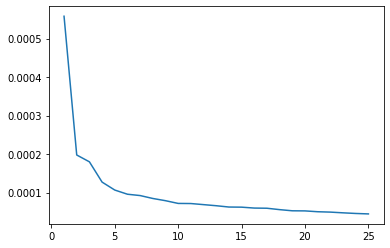

In [109]:
# do u need to standardize your data first?
famd = prince.FAMD(
    n_components = 25
)
famd = famd.fit(df_temp3.drop('SalePrice', axis='columns'))

import matplotlib.pyplot as plt
plt.plot([i for i in range(1,26)],famd.eigenvalues_)


No handles with labels found to put in legend.


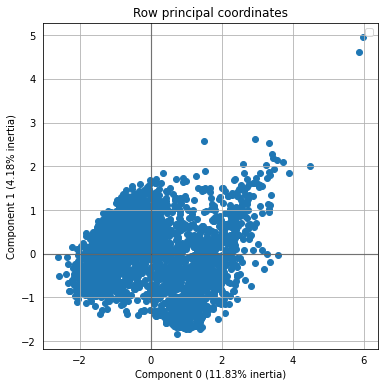

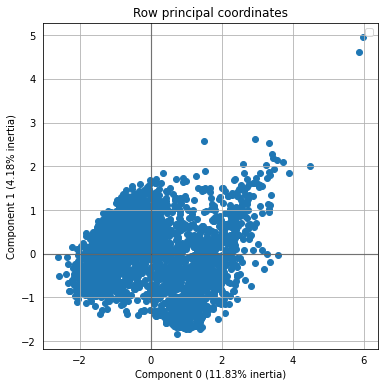

In [51]:
ax = famd.plot_row_coordinates(
     df_temp2,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     #labels=df_temp2.index,
     #color_labels=['{}'.format(t) for t in df_temp2.index],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
)
ax.get_figure()#.savefig('images/famd_row_coordinates.svg')

## Exploration - Generating new variables

## Visualisation

## Modelling - Data Processing

## Modelling - Choice of model to use

## Evaluating model performance

## References